In [0]:
import os
from typing import List, Dict
import re
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import boto3
from boto3.dynamodb.conditions import Key
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb

In [0]:
df_stockprice_7203 = pd.read_csv('s3://fin-app/stockprice_concat/7203.csv')

In [0]:
df_stockprice_7203['日付'] = pd.to_datetime(df_stockprice_7203['日付'])

In [0]:
df_stockprice_7203 = df_stockprice_7203.set_index('日付')

In [0]:
_aws_session = boto3.session.Session(
    region_name='ap-northeast-1',
    aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
    aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
)

DYNAMO_DB = _aws_session.resource('dynamodb')

In [0]:
class DynamoDB:

    @staticmethod
    def put_items(
        table_name: str,
        items: List[Dict],
        use_batch_writer: bool = False,
    ) -> List:
        """[summary]
        
        Args:
            table_name (str): [description]
            items (List[Dict]): [description]
        
        Raises:
            e: [description]
        
        Returns:
            List: [description]
        """
        if not isinstance(items, list):
            items = [items]

        responses = []
        try:
            table = DYNAMO_DB.Table(table_name)
        except Exception as e:
            print(f'Failed at DYNAMO_DB.Table(table_name) : {e}')
            raise e

        if use_batch_writer:
            with table.batch_writer() as batch:
                for item in items:
                    try:
                        responses.append(
                            batch.put_item(
                                Item=item,
                            )
                        )
                    except Exception as e:
                        print(f'Failed to put data to DynamoDB. Skipping : {e}')
        else:
            for item in items:
                try:
                    responses.append(
                        table.put_item(
                            TableName=table_name,
                            Item=item,
                        )
                    )
                except Exception as e:
                    print(f'Failed to put data to DynamoDB. Skipping : {e}')

        return responses

    @staticmethod
    def partitionkey_query(
        table_name: str,
        partition_key_name: str,
        partition_key: str,
    ) -> List[Dict]:
        try:
            table = DYNAMO_DB.Table(table_name)
        except Exception as e:
            print(f'Failed at DYNAMO_DB.Table(table_name) : {e}')
            raise e

        try:
            response = table.query(
                KeyConditionExpression=Key(partition_key_name).eq(partition_key)
            )
        except Exception as e:
            print(f'Failed to query : {e}')
            return []

        return response['Items']

In [0]:
res = DynamoDB.partitionkey_query(
    table_name='finapp_company_announcements',
    partition_key_name='company_code',
    partition_key=72030,
)

In [16]:
res

[{'company_code': Decimal('72030'),
  'company_name': 'トヨタ自',
  'document_url': 'https://webapi.yanoshin.jp/rd.php?https://www.release.tdnet.info/inbs/140120100120000001.pdf',
  'id': '20800',
  'markets_string': '東大名札福',
  'pubdate': '2010-02-04 15:00:00',
  'title': '業績予想の修正に関するお知らせ',
  'update_history': None,
  'url_report_type_earnings_forecast': 'https://www.release.tdnet.info/inbs/090920100120000001.html',
  'url_report_type_expected_dividends': None,
  'url_report_type_fs_consolidated': None,
  'url_report_type_fs_non_consolidated': None,
  'url_report_type_summary': None,
  'url_xbrl': 'https://webapi.yanoshin.jp/rd.php?https://www.release.tdnet.info/inbs/091220100120000001.zip'},
 {'company_code': Decimal('72030'),
  'company_name': 'トヨタ自',
  'document_url': 'https://webapi.yanoshin.jp/rd.php?https://www.release.tdnet.info/inbs/140120100125003433.pdf',
  'id': '20801',
  'markets_string': '東大名札福',
  'pubdate': '2010-02-04 15:00:00',
  'title': '平成22年3月期 第3四半期決算短信〔米国会計基準〕',
  '

In [17]:
len(res)

203

In [0]:
pub_dates = [datetime.strptime(r['pubdate'], '%Y-%m-%d %H:%M:%S') for r in res]
titles = [r['title'] for r in res]
document_urls = [r['document_url'] for r in res]

In [19]:
pub_dates

[datetime.datetime(2010, 2, 4, 15, 0),
 datetime.datetime(2010, 2, 4, 15, 0),
 datetime.datetime(2010, 2, 9, 20, 0),
 datetime.datetime(2010, 2, 18, 12, 15),
 datetime.datetime(2010, 2, 22, 21, 0),
 datetime.datetime(2010, 3, 23, 8, 45),
 datetime.datetime(2010, 3, 30, 9, 10),
 datetime.datetime(2010, 3, 30, 19, 0),
 datetime.datetime(2010, 4, 7, 10, 15),
 datetime.datetime(2010, 4, 7, 16, 0),
 datetime.datetime(2010, 4, 20, 8, 30),
 datetime.datetime(2010, 4, 20, 18, 10),
 datetime.datetime(2010, 5, 11, 18, 30),
 datetime.datetime(2010, 5, 21, 18, 0),
 datetime.datetime(2010, 5, 24, 15, 35),
 datetime.datetime(2010, 7, 12, 15, 10),
 datetime.datetime(2010, 7, 15, 16, 0),
 datetime.datetime(2010, 7, 20, 15, 0),
 datetime.datetime(2010, 7, 26, 9, 0),
 datetime.datetime(2010, 8, 4, 15, 0),
 datetime.datetime(2010, 8, 2, 17, 0),
 datetime.datetime(2010, 8, 4, 15, 0),
 datetime.datetime(2010, 10, 25, 9, 0),
 datetime.datetime(2010, 12, 21, 13, 0),
 datetime.datetime(2011, 3, 9, 16, 0),
 da

In [20]:
titles

['業績予想の修正に関するお知らせ',
 '平成22年3月期 第3四半期決算短信〔米国会計基準〕',
 'プリウス等に関するリコールについて',
 '当社製品の品質に関する取組みについて',
 '連邦大陪審および米国証券取引委員会からの召喚状受領について',
 '当社の人事に関する一部報道について',
 'トヨタとマツダ、ハイブリッドシステムの技術ライセンス供与に合意',
 'お客様視点での取り組みの強化に向けた抜本的見直しの実施について',
 '当社の配当に関する一部報道について',
 '当社製品の品質に関する投資家向け説明会の実施について',
 'ＮＨＴＳＡからの制裁金に関して',
 '役員人事について',
 '平成22年3月期決算公表に関する記者会見について',
 '電気自動車に関するテスラモーターズとの業務提携について',
 '会社分割（簡易吸収分割）による住宅事業の子会社への継承に関するお知らせ',
 '当社の品質保証体制の改善に関する外部専門家の評価報告書について',
 'ストックオプションとしての新株予約権の割当に関するお知らせ',
 '連邦大陪審からの召喚状受領について',
 '当社の業績に関する一部報道について',
 '平成23年3月期 第1四半期決算短信〔米国会計基準〕 (連結)',
 'ストックオプションとしての新株予約権の発行内容確定に関するお知らせ',
 '業績予想の修正に関するお知らせ',
 '当社の業績に関する一部報道について',
 'NHTSAとの和解に関して',
 '役員人事について',
 'グローバルビジョンの公表について',
 '東北関東大震災の影響による当社の部品調達および生産の状況に関するお知らせ',
 '東日本大震災の影響による当社の国内および海外工場の稼働状況に関するお知らせ',
 '東日本大震災の影響による当社国内工場の稼働状況に関するお知らせ',
 '東日本大震災の影響による当社北米工場の稼動状況に関するお知らせ',
 '東日本大震災の影響による当社欧州工場の稼働状況に関するお知らせ',
 '当社業績予想の開示時期に関する一部報道について',
 '東日本大震災の影響による5月10日以降の当社国内工場の稼働状況に関するお知らせ',
 '東日本大震災の影響による4月26日以降の当社北米工場の稼動状況に関するお知らせ',


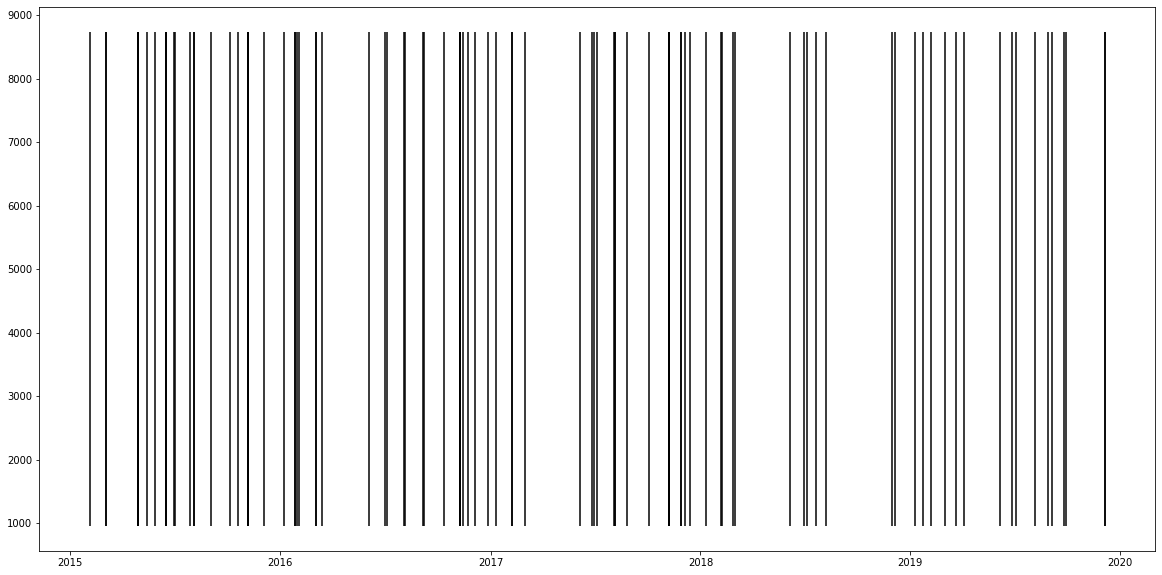

In [22]:
plt.figure(figsize=(20, 10))
plt.vlines(
    pub_dates[-100:],
    ymin=df_stockprice_7203['終値'].min(),
    ymax=df_stockprice_7203['終値'].max(),
)

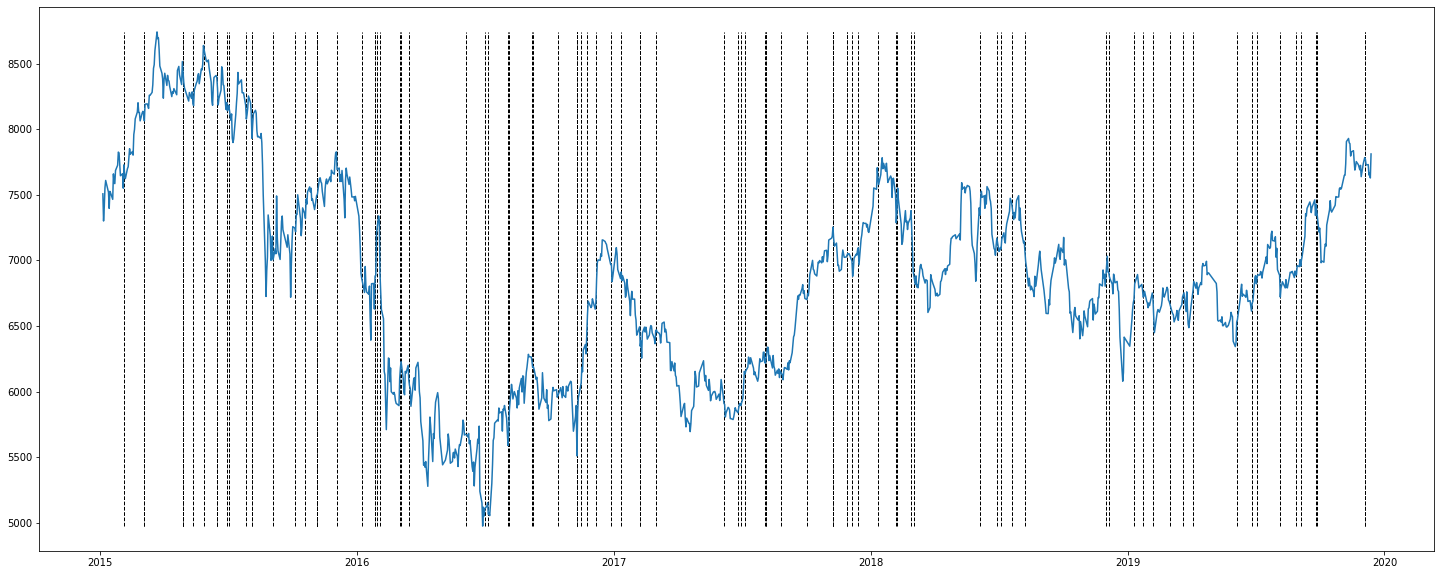

In [23]:
start_dt = '2015-01-01'

plt.figure(figsize=(25, 10))

dts = [i.to_pydatetime() for i in df_stockprice_7203[start_dt:]['終値'].index]

plt.plot(
    dts,
    df_stockprice_7203[start_dt:]['終値']
)
plt.vlines(
    pub_dates[-100:],
    ymin=df_stockprice_7203[start_dt:]['終値'].min(),
    ymax=df_stockprice_7203[start_dt:]['終値'].max(),
    color='k', linewidth=1.0, linestyle='--'
)

In [49]:
change_rates = []

for pub_date in pb(pub_dates):
    for i in range(100):
        try:
            base_price = df_stockprice_7203['終値'].loc[(pub_date-timedelta(days=i+1)).strftime('%Y-%m-%d')]
            cr = (df_stockprice_7203['終値'][pub_date+timedelta(days=1):pub_date+timedelta(days=30)] - base_price).mean() / base_price
            change_rates.append(cr)
            break
        except Exception as e:
            # print(e)
            continue

In [50]:
len(change_rates)

203

In [0]:
df_change_rate = pd.DataFrame({
    'pub_date': pub_dates,
    'title': titles,
    'change_rate_30d': change_rates,
    # 'document_url': document_urls,
})

In [0]:
def make_clickable(val):
    return '<a href="{}">{}</a>'.format(val,val)

In [74]:
df_change_rate.sort_values(by='change_rate_30d', ascending=False)

,pub_date,title,change_rate_30d
150,2016-11-14 15:10:00,一部報道について,0.118540
143,2016-11-08 15:00:00,平成29年3月期 第2四半期決算短信〔米国基準〕（連結）,0.109793
147,2016-11-08 15:00:00,剰余金の配当（中間配当）に関するお知らせ,0.109793
148,2016-11-08 15:00:00,自己株式の消却に関するお知らせ,0.109793
149,2016-11-08 15:00:00,自己株式取得に係る事項の決定に関するお知らせ,0.109793
...,...,...,...
42,2011-08-02 15:00:00,平成24年3月期 第１四半期決算短信〔米国基準〕(連結),-0.105348
41,2011-08-02 15:00:00,業績予想の修正に関するお知らせ,-0.105348
24,2011-03-09 16:00:00,役員人事について,-0.107770
25,2011-03-09 16:00:00,グローバルビジョンの公表について,-0.107770


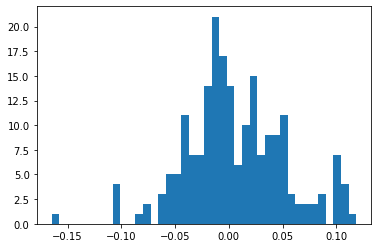

In [56]:
_ = plt.hist(change_rates, bins=40)